## Multi-class Model Development with PWM

> Written by Jess Breda August 2023

For this notebook, I'm going to focus on fitting a single animal (W065) since they are "trained" before the violations stopped being tracked, and they have 50K trials pre-violation cutoff. See `create_violation_dataset.ipynb` for supporting figures

In [4]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from scipy.optimize import minimize
from scipy.signal import lfilter
from sklearn.model_selection import KFold, train_test_split

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

### Data Load 

In [6]:
if platform.system() == "Windows":
    DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
else:
    if MODE == "cup":
        DATA_PATH = pathlib.Path("/Volumes/brody/jbreda/learning_project/data")
    elif MODE == "local":
        DATA_PATH = pathlib.Path("/Users/jessbreda/Desktop/github/animal-learning/data")
F_NAME = "processed/violation_data.csv"
ANIMAL_ID = "W065"

In [7]:
RAT_DF = pd.read_csv(DATA_PATH / F_NAME)
df = RAT_DF.query("animal_id == @ANIMAL_ID").copy()
df.reset_index(drop=True, inplace=True)

### Create Design Matrix

In [4]:
# def create_features_and_targets(df, animal_id, n_trials):
#     animal_df = df.query("animal_id == @animal_id").copy()
#     animal_df = animal_df[:n_trials]

#     X = pd.DataFrame()

#     return X, y

In [5]:
X = pd.DataFrame()

# normalize sa/sb to standard normal
X["s_a"] = (df.s_a - df.s_a.mean()) / df.s_a.std()
X["s_b"] = (df.s_b - df.s_b.mean()) / df.s_b.std()

# mask session boundaries to 0
session_boundaries_mask = df["session"].diff() == 0

# prev violation 0, 1, use as regressor & mask
X["prev_violation"] = (df.violation.shift() * session_boundaries_mask).fillna(0)
prev_violation_mask = X.prev_violation == 0

# get average stimulus loudness from previous trial (if exists)
# and normalize to standard normal
# here we assume, if prev trial was violation, sound avg is 0
X["prev_sound_avg"] = df[["s_a", "s_b"]].shift().mean(axis=1)
X["prev_sound_avg"] = (
    X.prev_sound_avg - X.prev_sound_avg.mean()
) / X.prev_sound_avg.std()
X["prev_sound_avg"] = X.prev_sound_avg * session_boundaries_mask * prev_violation_mask

# prev correct side (L, R) (0, 1) -> (-1, 1), violation and
# session boundary -> 0
X["prev_correct"] = (
    df.correct_side.replace({0: -1}).astype(int).shift()
    * session_boundaries_mask
    * prev_violation_mask
)

# prev choice regressors (L, R) (0, 1) -> (-1, 1), violation nan -> 0
# and session boundary -> 0
X["prev_choice"] = (
    df.choice.replace({0: -1}).fillna(0).astype(int).shift() * session_boundaries_mask
)

X.fillna(0, inplace=True)  # shifts make trial 0 nan, remove
X.insert(0, "bias", 1)


Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50105 entries, 0 to 50104
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bias            50105 non-null  int64  
 1   s_a             50105 non-null  float64
 2   s_b             50105 non-null  float64
 3   prev_violation  50105 non-null  int64  
 4   prev_sound_avg  50105 non-null  float64
 5   prev_correct    50105 non-null  float64
 6   prev_choice     50105 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 2.7 MB


Text(0.5, 1.0, 'Kernal $\\tau = 5$')

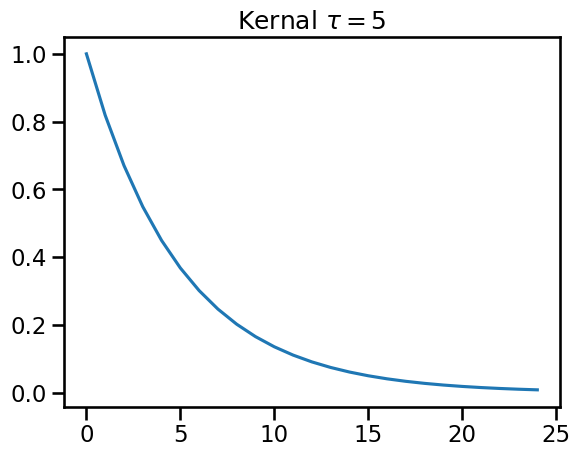

In [7]:
# Time Constant
tau = 5

# Exponential kernel
kernel = np.array([np.exp(-i / tau) for i in range(5 * tau)])

# Convolve the kernel with the violation column
convolution_result = np.convolve(df["violation"], kernel, mode="full")[: len(df)]

# # Add the convolution result to a new column in the dataframe
# X[f"exp_violation_{tau}"] = convolution_result

# Plot the kernel to visualize
plt.plot(kernel)
plt.title(f"Kernal $\\tau = {tau}$")

In [8]:
plt.plot(X[f"exp_violation_{tau}"].tail(10))

KeyError: 'exp_violation_5'

In [ ]:
import pandas as pd
import numpy as np

# Sample data
data = {"violation": [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]}
data = {"violation": [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]}
df = pd.DataFrame(data)

# Time constant
tau = 5
# Exponential kernel
kernel = np.array([np.exp(-i / tau) for i in range(5 * tau)])
# kernel = kernel / kernel.sum()  # normalize

# Convolve the kernel with the violation column
convolution_result = np.convolve(df["violation"], kernel, mode="full")[: len(df)]

# Add the convolution result to a new column in the dataframe
df["exp_violation_filter"] = convolution_result

# print(df)

Text(0.5, 0, 'Trial')

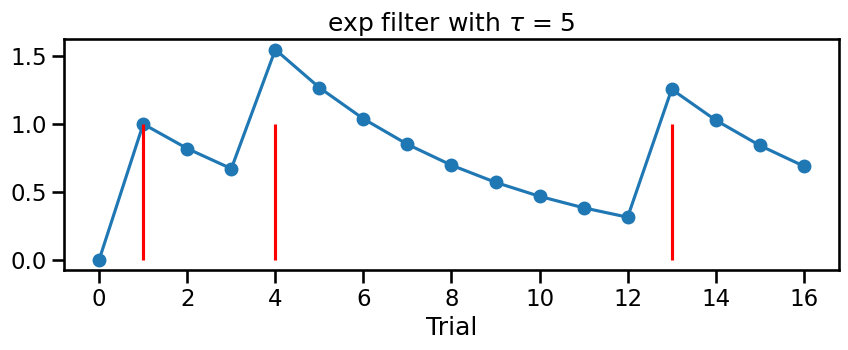

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df["exp_violation_filter"], label="Filter", marker="o")

# Iterate through the prev_violation column and plot vertical lines when the value is 1
for idx, value in df["violation"].items():
    if value == 1:
        plt.vlines(x=idx, ymin=0, ymax=1, color="r")


plt.title(f"exp filter with $\\tau$ = {tau}")
plt.xlabel("Trial")

Text(0.5, 1.0, 'Filtered Violations + Violations, $\\tau$ = 5')

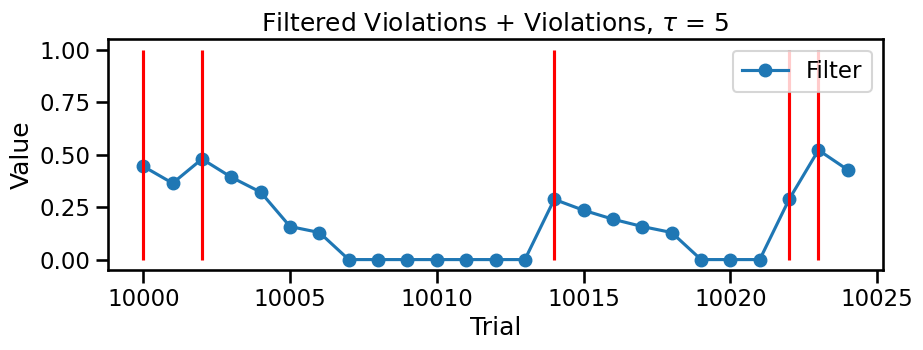

In [ ]:
plt.figure(figsize=(10, 3))
# Select the last 100 `rows
subset_df = X.iloc[10000:10025]
subset_main = df.iloc[10000:10025]
# subset_df = X.tail(100)
# subset_main = df.tail(100)
# subset_df = X.iloc[3457:3472]
# subset_main = df.iloc[3457:3472]
# Plot the filtered_prev_violation as a line plot
plt.plot(subset_df.index, subset_df[f"exp_violation_{tau}"], label="Filter", marker="o")

# Iterate through the prev_violation column and plot vertical lines when the value is 1
for idx, value in subset_main["violation"].items():
    if value == 1:
        plt.vlines(x=idx, ymin=0, ymax=1, color="r")

plt.xlabel("Trial")
plt.ylabel("Value")
plt.legend()
plt.title(f"Filtered Violations + Violations, $\\tau$ = {tau}")

In [ ]:
## NICKS CODE
# df = df[:first]  # restrict to "first" trials of data
# # remove sessions with fewer than "cutoff" valid trials
# df = df.groupby("session").filter(lambda x: len(x) >= cutoff)

# # Normalize the stimuli to standard normal
# s_a = (df["s_a"] - np.mean(df["s_a"])) / np.std(df["s_a"])
# s_b = (df["s_b"] - np.mean(df["s_b"])) / np.std(df["s_b"])

# # Determine which trials do not have a valid previous trial (mistrial or session boundary)
# t = np.array(df["trial"])
# prior = ((t[1:] - t[:-1]) == 1).astype(int)
# prior = np.hstack(([0], prior))

# # Calculate previous average tone value
# s_avg = (df["s_a"][:-1] + df["s_b"][:-1]) / 2
# s_avg = (s_avg - np.mean(s_avg)) / np.std(s_avg)
# s_avg = np.hstack(([0], s_avg))
# s_avg = s_avg * prior  # for trials without a valid previous trial, set to 0

# # Calculate previous correct answer
# h = (df["correct_side"][:-1] * 2 - 1).astype(int)  # map from (0,1) to (-1,1)
# h = np.hstack(([0], h))
# h = h * prior  # for trials without a valid previous trial, set to 0

# # Calculate previous choice
# c = (df["choice"][:-1] * 2 - 1).astype(int)  # map from (0,1) to (-1,1)
# c = np.hstack(([0], c))
# c = c * prior  # for trials without a valid previous trial, set to 0

### Fit Data

In [58]:
## Function for Multi-class Logistic Regression
def log_sum_exp(logits):
    """
    Compute the log of the sum of exponentials in a
    numerically stable way by subtracting off the largest
    logit.
    """
    max_logits = np.max(logits, axis=1, keepdims=True)
    return (
        np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True)) + max_logits
    )


def stable_softmax(logits):
    # use log-sum-exp for numerical stability
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))

    # sum over classes & normalize
    sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
    return exp_logits / sum_exp


def multiclass_logistic_cost(W, X, Y, sigma=None):
    """
    Compute the negative log-likelihood for multi-class
    logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C) or flattened (D+1 * C),
        will be in flattened form if in use for minimze() function
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - nll: Regularized negative log-likelihood
    """

    # reshape if from flat -> matrix if needed
    if len(W.shape) == 1:
        _, D_w_bias = X.shape
        _, C = Y.shape
        W = W.reshape(D_w_bias, C)

    logits = X @ W

    if sigma:
        penalty = 1 / (2 * (sigma**2)) * np.trace(W[1:, :].T @ W[1:, :])
    else:
        penalty = 0

    nll = (-np.sum(Y * logits) + np.sum(log_sum_exp(logits))) + penalty
    return nll


def multiclass_logistic_gradient(W, X, Y, sigma=None):
    """
    Compute the gradient of the negative log-likelihood for
    multi-class logistic regression with L2 regularization (or MAP).

    params:
    ------
    W: Weights matrix of shape (D+1, C) or flattened (D+1 * C),
        will be in flattened form if in use for minimze() function
    X: Data matrix of shape (N, D+1)
    Y: One-hot encoded labels of shape (N, C)
    sigma : float (default: None)
        Standard deviation of Gaussian prior, if None
        no regularization is applied.

    Returns:
    - gradient : Gradient of shape (D+1, C)
    """

    # reshape if from flat -> matrix if needed
    if len(W.shape) == 1:
        _, D_w_bias = X.shape
        _, C = Y.shape
        W = W.reshape(D_w_bias, C)

    logits = X @ W
    P = stable_softmax(logits)

    if sigma:
        penalty_gradient = W / (sigma**2)
        penalty_gradient[0, :] = 0  # No penalty for bias
    else:
        penalty_gradient = 0

    gradient = X.T @ (P - Y) + penalty_gradient
    return gradient.flatten()

In [ ]:
# def cost_function_to_minimize(W_flat, X, Y, sigma=None):
#     W_matrix = W_flat.reshape(D + 1, C)
#     return multiclass_logistic_cost(W_matrix, X, Y, sigma)


# def gradient_function_to_minimize(W_flat, X, Y, sigma=None):
#     W_matrix = W_flat.reshape(D+1, C)
#     grad_matrix = multiclass_logistic_gradient(W_matrix, X, Y, sigma)
#     return grad_matrix.flatten()

In [51]:
_, D_w_bias = XX.shape
_, C = YY.shape
D_w_bias, C

(9, 3)

In [52]:
initial_W_flat.reshape(D_w_bias, C)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [57]:
multiclass_logistic_cost(
    initial_W_flat,
    XX.to_numpy(),
    YY,
)

55045.968723715625

In [68]:
def fit_multiclass(X, Y, sigma=None, disp=True):
    """
    function to fit multiclass logistic regression model
    using scipy.optimize.minimize() function

    params
    ------
    X : pd.DataFrame, shape (N, D + 1)
        design matrix with bias column
    Y : np.ndarray, shape (N, C), where C = 3
        one-hot encoded choice labels for each trial as left,
        right or violation
    sigma : float (default=None)
        standard deviation of Gaussian prior, if None no
        regularization is applied
    disp : bool (default=True)
        if True, print convergence message from minimize()
    
    returns
    -------
    W : np.ndarray, shape (D + 1, C)
        optimized weights matrix
    """
    # initialize dimensions
    N = len(X)
    D = X.shape[1] - 1
    C = Y.shape[1]

    # initalize weights
    initial_W_flat = np.zeros((D + 1) * C)

    # Optimization using BFGS
    result = minimize(
        fun=multiclass_logistic_cost,
        x0=initial_W_flat,
        args=(X.to_numpy(), Y, sigma),
        method="BFGS",
        jac=multiclass_logistic_gradient,
        options={"disp": disp},
    )

    return result.x.reshape(D + 1, C)

In [70]:
optW = fit_multiclass(XX, YY, sigma=3.0)

Optimization terminated successfully.
         Current function value: 34596.835414
         Iterations: 33
         Function evaluations: 42
         Gradient evaluations: 42


In [60]:
# Initial weights
initial_W_flat = np.zeros((D + 1) * C)
sigma = 1.5

# Optimization using L-BFGS-B
result = minimize(
    fun=multiclass_logistic_cost,
    x0=initial_W_flat,
    args=(XX.to_numpy(), YY, sigma),
    method="BFGS",
    jac=multiclass_logistic_gradient,
    options={"disp": True},
)
optimized_W = result.x.reshape(D + 1, C)

         Current function value: 34644.498626
         Iterations: 32
         Function evaluations: 130
         Gradient evaluations: 117


### Visualize

In [ ]:
def plot_weight_differences(X, optimized_W):
    """
    Plot the differences between consecutive as bar charts.

    Parameters:
    - X: data frame of design matrix
    - optimized_W: weights obtained after optimization

    Returns:
    - plots the differences.
    """

    # Number of classes
    D_w_bias = optimized_W.shape[0]
    C = optimized_W.shape[1]

    # Prepare data for Seaborn
    diff_data = []
    for c in range(C - 1):
        differences = optimized_W[:, c] - optimized_W[:, c + 1]
        for i, diff in enumerate(differences):
            diff_data.append(
                {
                    "Difference": diff,
                    "Feature": X.columns[i],
                    "Pairing": f"Weights {c+1} - {c+2}",
                }
            )

    df_diff = pd.DataFrame(diff_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x="Feature", y="Difference", hue="Pairing", data=df_diff, ax=ax)
    ax.axhline(y=0, color="black")
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")


def plot_class_weights(X, optimized_W):
    """
    Plot the weights for each feature and class as bar charts.

    Parameters:
    - X: data frame of design matrix (N x D)
    - optimized_W: weights obtained after optimization (D x C)

    Returns:
    - plots the weights.
    """

    # Extract shape details
    D, C = optimized_W.shape
    classes = ["L", "R", "V"]

    # Prepare data for Seaborn
    weight_data = []
    for c in range(C):
        for d in range(D):
            weight_data.append(
                {
                    "Weight": optimized_W[d, c],
                    "Feature": X.columns[d],
                    "Class": classes[c],
                }
            )

    df_weights = pd.DataFrame(weight_data)

    # Plot using Seaborn
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.axhline(y=0, color="black")
    sns.barplot(x="Feature", y="Weight", hue="Class", data=df_weights, ax=ax)
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")

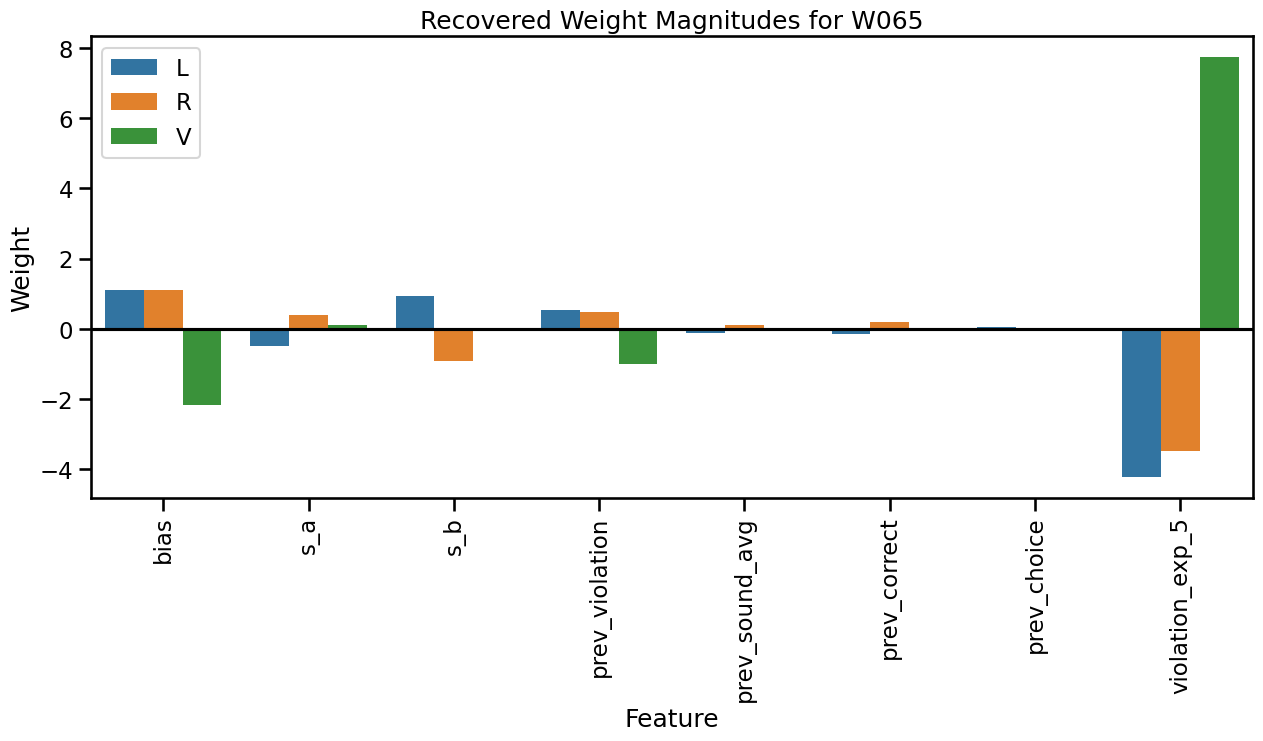

In [86]:
# Call the function
plot_class_weights(X, optimized_W)
plt.title("Recovered Weight Magnitudes for W065")
plt.legend(loc="upper left")

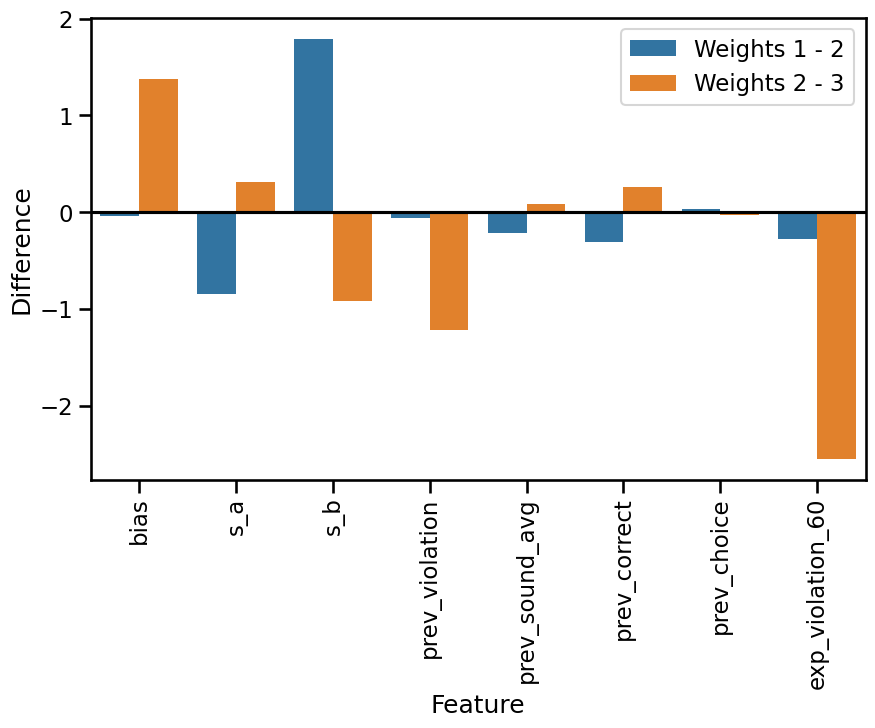

In [216]:
plot_weight_differences(X, optimized_W)

In [8]:
from generate_design_matrix import *
from get_rat_data import *

from multiclass_logistic_regression import fit_multiclass

df = get_rat_viol_data(animal_id=ANIMAL_ID)
taus = [5, 30]
columns_to_filter = ["violation"]
XX, YY = generate_design_mat_and_labels(df, columns_to_filter, taus)
assert len(XX) == len(YY), "X and Y must have same number of rows"

returning data for W065
Exp filter added | Column: violation, Tau: 5
Exp filter added | Column: violation, Tau: 30

Design Matrix generated with features:
 Index(['bias', 's_a', 's_b', 'prev_violation', 'prev_sound_avg',
       'prev_correct', 'prev_choice', 'violation_exp_5', 'violation_exp_30'],
      dtype='object')


In [9]:
fit_multiclass(XX, YY, sigma=3)

Optimization terminated successfully.
         Current function value: 34596.835414
         Iterations: 33
         Function evaluations: 42
         Gradient evaluations: 42


array([[ 7.63824986e-01,  7.56304491e-01, -1.52012948e+00],
       [-4.73908556e-01,  4.01164645e-01,  7.27439105e-02],
       [ 9.24040771e-01, -9.52603465e-01,  2.85626937e-02],
       [ 7.45921634e-01,  7.10417762e-01, -1.45633940e+00],
       [-1.10560702e-01,  1.26498811e-01, -1.59381091e-02],
       [-1.35675415e-01,  1.86939803e-01, -5.12643882e-02],
       [ 3.85826654e-02,  7.39343041e-03, -4.59760958e-02],
       [-6.45209935e+00, -5.80318651e+00,  1.22552859e+01],
       [ 3.06983589e+00,  3.18362733e+00, -6.25346322e+00]])

Currently dealing with shape issues with XX and YY and W-flat-

In [89]:
# FITTING FUNCTION HERE

N = len(X)
D = X.shape[1] - 1
C = Y.shape[1]
# Initial weights
initial_W_flat = np.zeros((D + 1) * C)
sigma = 1.5

# Optimization using L-BFGS-B
result = minimize(
    fun=multiclass_logistic_cost,
    x0=initial_W_flat,
    args=(X.to_numpy(), Y, sigma),
    method="BFGS",
    jac=multiclass_logistic_gradient,
    options={"disp": True},
)
optimized_W = result.x.reshape(D + 1, C)


Notes for (eventual eval):
```
test_nlls = np.zeros(len(taus))
# iterate over train, taus
    # store out
    test_nlls.append(multiclass_logistic_cost(optimized_W, X_test, Y_test, sigma=None))
```

-